Import Files


In [ ]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving clean.csv to clean.csv


In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R

install.packages("caret")
install.packages("MASS")

library(MASS)
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’

trying URL 'https://cran.rstudio.com/src/contrib/listenv_0.9.1.tar.gz'
Content type 'application/x-gzip' length 36600 bytes (35 KB)
downloaded 35 KB

trying URL 'https://cran.rstudio.com/src/contrib/parallelly_1.43.0.tar.gz'
Content type 'application/x-gzip' length 310739 bytes (303 KB)
downloaded 303 KB

trying URL 'https://cran.rstudio.com/src/contrib/future_1.34.0.tar.gz'
Content type 'application/x-gzip' length 359503 bytes (351 KB)
downloaded 351 KB

trying URL 'https://cran.rstudio.com/src/contrib/globals_0.16.3.tar.gz'
Content type 'application/x-gzip' length 37475 bytes (

Deal with Categorical Variables


In [ ]:
%%R

data <- read.csv('clean.csv')

# Frequency encode categorical variables
rating_counts <- table(data$rating)
data$rating_encoded <- as.numeric(rating_counts[data$rating])

risk_rating_counts <- table(data$risk_rating)
data$risk_rating_encoded <- as.numeric(risk_rating_counts[data$risk_rating])

equity_category_counts <- table(data$category)
data$equity_category_encoded <- as.numeric(equity_category_counts[data$category])

data <- data[, setdiff(names(data), c("rating", "risk_rating", "category"))]
dim(data)

[1] 1248   14


Mean and SD for Response Variables

In [ ]:
%%R

mean_roe <- mean(data$roe, na.rm = TRUE)
sd_roe <- sd(data$roe, na.rm = TRUE)

mean_sustainability <- mean(data$sustainability_score, na.rm = TRUE)
sd_sustainability <- sd(data$sustainability_score, na.rm = TRUE)

cat("Mean ROE:", mean_roe, "\n")
cat("SD ROE:", sd_roe, "\n")
cat("Mean Sustainability Score:", mean_sustainability, "\n")
cat("SD Sustainability Score:", sd_sustainability, "\n")

Mean ROE: 15.09017 
SD ROE: 7.874945 
Mean Sustainability Score: 23.60682 
SD Sustainability Score: 3.570292 


Checking Matrix Rank

In [ ]:
%%R

X <- data[, setdiff(names(data), c("roe", "sustainability_score"))]
qr(X)$rank == ncol(X)

[1] TRUE


Function to evaluate model fit using Normalized RMSE (nRMSE)

In [ ]:
%%R

calculate_nrmse <- function(model, data) {

  response_vars <- c("roe", "sustainability_score")
  residuals_matrix <- as.matrix(residuals(model))

  # na.rm = TRUE handles missing values
  rmse_per_response <- apply(residuals_matrix, 2, function(residuals) {
    sqrt(mean(residuals^2, na.rm = TRUE))
  })

  # Calculate standard deviation of each response variable
  std_devs <- apply(data[, response_vars, drop = FALSE], 2, function(column) {
    sd(column, na.rm = TRUE)
  })

  # Handle cases where standard deviation is zero (avoid division by zero)
  if (any(std_devs == 0)) {
    warning("One or more response variables have zero standard deviation. Returning NA.")
    return(NA)
  }

  # Compute Normalised RMSE (nRMSE) by averaging across responses
  nrmse <- mean(rmse_per_response / std_devs, na.rm = TRUE)

  return(nrmse)
}

multi_model <- lm(cbind(roe, sustainability_score)~., data = data)
print(calculate_nrmse(multi_model, data))

[1] 0.7606132


Add Predictors Function

In [ ]:
%%R
add_predictors <- function(data, response_vars, selected_predictors, remaining_predictors) {

  # Stores MANOVA p values for each predictor and its corresponding regression model
  manova_p_values <- c()
  candidate_models <- list()

  for (predictor in remaining_predictors) {
    # Multivariate regression formula
    formula <- as.formula(
      paste0("cbind(", paste(response_vars, collapse = ", "), ") ~ ",
             paste(c(selected_predictors, predictor), collapse = " + "))
    )

    # Fit the multivariate regression model and perform MANOVA using the Wilks' Lambda Test
    model <- lm(formula, data = data)
    manova_model <- manova(model)
    manova_test <- summary(manova_model, test = "Wilks")

    p_value <- manova_test$stats[1, "Pr(>F)"]

    manova_p_values <- c(manova_p_values, p_value)
    candidate_models[[predictor]] <- list(model = model, p_value = p_value)
  }

  return(list(manova_p_values = manova_p_values, candidate_models = candidate_models))
}

Remove Predictors Function - similar logic to the above


In [ ]:
%%R

remove_predictors <- function(data, response_vars, selected_predictors) {
  manova_p_values <- c()
  candidate_models <- list()

  for (predictor in selected_predictors) {
    remaining_predictors <- setdiff(selected_predictors, predictor)

    if (length(remaining_predictors) > 0) {
      # Construct the formula for multivariate regression
      formula <- as.formula(
        paste0("cbind(", paste(response_vars, collapse = ", "), ") ~ ",
               paste(remaining_predictors, collapse = " + "))
      )

      # Fit the multivariate regression model
      model <- lm(formula, data = data)

      # Perform MANOVA
      manova_model <- manova(model)
      manova_test <- summary(manova_model, test = "Wilks")

      # Extract Wilks' Lambda p-value
      p_value <- manova_test$stats[1, "Pr(>F)"]

      # Store results
      manova_p_values <- c(manova_p_values, p_value)
      candidate_models[[predictor]] <- list(model = model, p_value = p_value)
    }
  }

  return(list(manova_p_values = manova_p_values, candidate_models = candidate_models))
}


Previous Stepwise Multivariate

In [ ]:
%%R

stepwise_multivariate <- function(data, method = "bidirectional", k_folds = 5) {
  # Define response variables and predictors
  response_vars <- c("roe", "sustainability_score")
  predictors <- setdiff(names(data), response_vars)

  # Validate inputs
  if (!method %in% c("forward", "backward", "bidirectional")) {
    stop("Method must be 'forward', 'backward', or 'bidirectional'")
  }
  if (!all(response_vars %in% names(data))) {
    stop("Response variables not found in data")
  }
  if (length(predictors) == 0) {
    stop("No predictors available in the data")
  }

  # Initialize predictor sets based on method
  selected_predictors <- if (method == "forward") character(0) else predictors
  remaining_predictors <- if (method == "forward") predictors else character(0)

  best_model <- NULL
  best_metric <- Inf
  no_change_counter <- 0

  # Initialize history tracking
  stepwise_history <- data.frame(
    Step = integer(),
    NumPredictors = integer(),
    WilksLambda = numeric(),
    nRMSE = numeric()
  )

  repeat {
    candidate_models <- list()
    manova_p_values <- numeric()
    predictors_added <- FALSE
    predictors_removed <- FALSE

    # Forward step
    if (method %in% c("forward", "bidirectional") && length(remaining_predictors) > 0) {
      forward_results <- add_predictors(data, response_vars, selected_predictors, remaining_predictors)
      candidate_models <- forward_results$candidate_models
      manova_p_values <- forward_results$manova_p_values

      valid_indices <- which(!is.na(manova_p_values) & is.finite(manova_p_values))
      if (length(valid_indices) > 0) {
        best_index <- valid_indices[which.min(manova_p_values[valid_indices])]
        best_predictor <- names(candidate_models)[best_index]
        best_candidate_model <- candidate_models[[best_predictor]]$model
        best_candidate_metric <- calculate_nrmse(best_candidate_model, data)

        if (best_candidate_metric < best_metric) {
          best_model <- best_candidate_model
          best_metric <- best_candidate_metric
          selected_predictors <- c(selected_predictors, best_predictor)
          remaining_predictors <- setdiff(remaining_predictors, best_predictor)
          predictors_added <- TRUE
          message("Added Predictor: ", best_predictor)
        }
      }
    }

    # Backward step
    if (method %in% c("backward", "bidirectional") && length(selected_predictors) > 1) {
      backward_results <- remove_predictors(data, response_vars, selected_predictors)
      candidate_models <- backward_results$candidate_models
      manova_p_values <- backward_results$manova_p_values

      valid_indices <- which(!is.na(manova_p_values) & is.finite(manova_p_values))
      if (length(valid_indices) > 0) {
        worst_index <- valid_indices[which.max(manova_p_values[valid_indices])]
        worst_predictor <- names(candidate_models)[worst_index]
        best_candidate_model <- candidate_models[[worst_predictor]]$model
        best_candidate_metric <- calculate_nrmse(best_candidate_model, data)

        if (best_candidate_metric < best_metric) {
          best_model <- best_candidate_model
          best_metric <- best_candidate_metric
          selected_predictors <- setdiff(selected_predictors, worst_predictor)
          remaining_predictors <- c(remaining_predictors, worst_predictor)
          predictors_removed <- TRUE
          message("Removed Predictor: ", worst_predictor)
        }
      }
    }

    # Update stepwise history
    stepwise_history <- rbind(stepwise_history, data.frame(
      Step = if (nrow(stepwise_history) == 0) 1 else max(stepwise_history$Step) + 1,
      NumPredictors = length(selected_predictors),
      WilksLambda = if (length(manova_p_values) > 0) min(manova_p_values, na.rm = TRUE) else NA,
      nRMSE = best_metric
    ))

    # Check stopping criteria
    if (!predictors_added && !predictors_removed) {
      no_change_counter <- no_change_counter + 1
      message("No significant changes in step ", no_change_counter)
    } else {
      no_change_counter <- 0
    }

    if (no_change_counter >= 2) {
      message("Stopping selection after two consecutive failed modifications.")
      break
    }

    # Progress update
    message("Selected Predictors: ", paste(selected_predictors, collapse = ", "))
    message("Current nRMSE: ", best_metric)
  }

  # Return results
  list(
    model = best_model,
    selected_predictors = selected_predictors,
    stepwise_history = stepwise_history
  )
}

New Stepwise Multivariate

In [ ]:
%%R

stepwise_multivariate <- function(data, method = "bidirectional", k_folds = 5) {
  response_vars <- c("roe", "sustainability_score")
  predictors <- setdiff(names(data), response_vars)

  selected_predictors <- if (method == "forward") character(0) else predictors
  remaining_predictors <- if (method == "forward") predictors else character(0)

  best_model <- NULL
  best_metric <- Inf
  no_change_counter <- 0

  # Initialize storage for stepwise process tracking
  stepwise_history <- data.frame(Step = integer(), NumPredictors = integer(), WilksLambda = numeric(), nRMSE = numeric())

  repeat {
    # Collect all candidate models and actions
    candidate_models <- list()
    manova_p_values <- c()
    actions <- c()  # Track whether it's an add or remove
    predictors_added <- FALSE
    predictors_removed <- FALSE

    # Forward Step candidates
    if (method %in% c("forward", "bidirectional") && length(remaining_predictors) > 0) {
      forward_results <- add_predictors(data, response_vars, selected_predictors, remaining_predictors)
      candidate_models <- c(candidate_models, forward_results$candidate_models)
      manova_p_values <- c(manova_p_values, forward_results$manova_p_values)
      actions <- c(actions, paste0("add_", names(forward_results$candidate_models)))
    }

    # Backward Step candidates
    if (method %in% c("backward", "bidirectional") && length(selected_predictors) > 1) {
      backward_results <- remove_predictors(data, response_vars, selected_predictors)
      candidate_models <- c(candidate_models, backward_results$candidate_models)
      manova_p_values <- c(manova_p_values, backward_results$manova_p_values)
      actions <- c(actions, paste0("remove_", names(backward_results$candidate_models)))
    }

    # Evaluate all candidates together
    valid_indices <- which(!is.na(manova_p_values) & is.finite(manova_p_values))
    if (length(valid_indices) > 0) {
      best_index <- valid_indices[which.min(manova_p_values[valid_indices])]  # Smallest p-value = biggest MANOVA impact
      best_action <- actions[best_index]
      best_predictor <- sub("^(add|remove)_", "", best_action)
      best_candidate_model <- candidate_models[[best_index]]$model
      best_candidate_metric <- calculate_nrmse(best_candidate_model, data)

      if (best_candidate_metric < best_metric) {
        best_model <- best_candidate_model
        best_metric <- best_candidate_metric
        if (grepl("^add_", best_action)) {
          selected_predictors <- c(selected_predictors, best_predictor)
          remaining_predictors <- setdiff(remaining_predictors, best_predictor)
          predictors_added <- TRUE
          message("Added Predictor: ", best_predictor)
        } else {
          selected_predictors <- setdiff(selected_predictors, best_predictor)
          remaining_predictors <- c(remaining_predictors, best_predictor)
          predictors_removed <- TRUE
          message("Removed Predictor: ", best_predictor)
        }
      }
    }

    # Store stepwise process tracking
    stepwise_history <- rbind(stepwise_history, data.frame(
      Step = ifelse(nrow(stepwise_history) == 0, 1, max(stepwise_history$Step) + 1),
      NumPredictors = length(selected_predictors),
      WilksLambda = ifelse(length(manova_p_values) > 0, min(manova_p_values, na.rm = TRUE), NA),
      nRMSE = best_metric
    ))

    # Stopping Criteria
    if (!predictors_added && !predictors_removed) {
      no_change_counter <- no_change_counter + 1
      message("No significant changes in step ", no_change_counter)
    } else {
      no_change_counter <- 0
    }

    if (no_change_counter >= 2) {
      message("Stopping selection after two consecutive failed modifications.")
      break
    }

    message("Selected Predictors: ", paste(selected_predictors, collapse = ", "))
    message("Current nRMSE: ", best_metric)
  }

  # Return model and stepwise tracking data
  return(list(
    model = best_model,
    selected_predictors = selected_predictors,
    stepwise_history = stepwise_history
  ))
}

In [ ]:
%%R

# Updated calculate_nrmse with k-fold cross-validation
calculate_nrmse <- function(model, data, k_folds=5) {
  response_vars <- c("roe", "sustainability_score")

  # Extract predictors from the model
  predictor_vars <- all.vars(formula(model))[-c(1:2)]  # Exclude response vars (roe, sustainability_score)

  # Shuffle data for random folds
  n <- nrow(data)
  indices <- sample(1:n)
  fold_size <- n %/% k_folds
  nrmse_folds <- numeric(k_folds)

  for (i in 1:k_folds) {
    # Define test and train indices
    test_start <- (i - 1) * fold_size + 1
    test_end <- if (i == k_folds) n else i * fold_size
    test_idx <- indices[test_start:test_end]
    train_idx <- setdiff(indices, test_idx)

    # Split data
    train_data <- data[train_idx, ]
    test_data <- data[test_idx, ]

    # Refit the model on training data
    formula_str <- paste0("cbind(", paste(response_vars, collapse = ", "), ") ~ ",
                         paste(predictor_vars, collapse = " + "))
    train_model <- lm(as.formula(formula_str), data = train_data)

    # Predict on test data and compute residuals
    predictions <- predict(train_model, newdata = test_data)
    actuals <- as.matrix(test_data[, response_vars])
    residuals_matrix <- actuals - predictions

    # Compute RMSE per response
    rmse_per_response <- apply(residuals_matrix, 2, function(residuals) {
      sqrt(mean(residuals^2, na.rm = TRUE))
    })

    # Calculate standard deviation of each response variable (from full data, consistent with original)
    std_devs <- apply(data[, response_vars, drop = FALSE], 2, function(column) {
      sd(column, na.rm = TRUE)
    })

    # Handle zero standard deviation
    if (any(std_devs == 0)) {
      warning("One or more response variables have zero standard deviation in fold ", i, ". Using NA for this fold.")
      nrmse_folds[i] <- NA
    } else {
      nrmse_folds[i] <- mean(rmse_per_response / std_devs, na.rm = TRUE)
    }
  }

  # Return mean nRMSE across folds
  mean(nrmse_folds, na.rm = TRUE)
}

Cross-Validated Stepwise Multivariate

In [ ]:
%%R

stepwise_multivariate <- function(data, method = "bidirectional", k_folds = 5) {
  response_vars <- c("roe", "sustainability_score")
  predictors <- setdiff(names(data), response_vars)

  selected_predictors <- if (method == "forward") character(0) else predictors
  remaining_predictors <- if (method == "forward") predictors else character(0)

  best_model <- NULL
  best_metric <- Inf
  no_change_counter <- 0

  # Initialize storage for stepwise process tracking
  stepwise_history <- data.frame(Step = integer(), NumPredictors = integer(), WilksLambda = numeric(), nRMSE = numeric())

  repeat {
    # Collect all candidate models and actions
    candidate_models <- list()
    manova_p_values <- c()
    actions <- c()  # Track whether it's an add or remove
    predictors_added <- FALSE
    predictors_removed <- FALSE

    # Forward Step candidates
    if (method %in% c("forward", "bidirectional") && length(remaining_predictors) > 0) {
      forward_results <- add_predictors(data, response_vars, selected_predictors, remaining_predictors)
      candidate_models <- c(candidate_models, forward_results$candidate_models)
      manova_p_values <- c(manova_p_values, forward_results$manova_p_values)
      actions <- c(actions, paste0("add_", names(forward_results$candidate_models)))
    }

    # Backward Step candidates
    if (method %in% c("backward", "bidirectional") && length(selected_predictors) > 1) {
      backward_results <- remove_predictors(data, response_vars, selected_predictors)
      candidate_models <- c(candidate_models, backward_results$candidate_models)
      manova_p_values <- c(manova_p_values, backward_results$manova_p_values)
      actions <- c(actions, paste0("remove_", names(backward_results$candidate_models)))
    }

    # Evaluate all candidates together
    valid_indices <- which(!is.na(manova_p_values) & is.finite(manova_p_values))
    if (length(valid_indices) > 0) {
      best_index <- valid_indices[which.min(manova_p_values[valid_indices])]  # Smallest p-value = biggest MANOVA impact
      best_action <- actions[best_index]
      best_predictor <- sub("^(add|remove)_", "", best_action)
      best_candidate_model <- candidate_models[[best_index]]$model
      best_candidate_metric <- calculate_nrmse(best_candidate_model, data, k_folds)  # Pass k_folds

      if (best_candidate_metric < best_metric) {
        best_model <- best_candidate_model
        best_metric <- best_candidate_metric
        if (grepl("^add_", best_action)) {
          selected_predictors <- c(selected_predictors, best_predictor)
          remaining_predictors <- setdiff(remaining_predictors, best_predictor)
          predictors_added <- TRUE
          message("Added Predictor: ", best_predictor)
        } else {
          selected_predictors <- setdiff(selected_predictors, best_predictor)
          remaining_predictors <- c(remaining_predictors, best_predictor)
          predictors_removed <- TRUE
          message("Removed Predictor: ", best_predictor)
        }
      }
    }

    # Store stepwise process tracking
    stepwise_history <- rbind(stepwise_history, data.frame(
      Step = ifelse(nrow(stepwise_history) == 0, 1, max(stepwise_history$Step) + 1),
      NumPredictors = length(selected_predictors),
      WilksLambda = ifelse(length(manova_p_values) > 0, min(manova_p_values, na.rm = TRUE), NA),
      nRMSE = best_metric
    ))

    # Stopping Criteria
    if (!predictors_added && !predictors_removed) {
      no_change_counter <- no_change_counter + 1
      message("No significant changes in step ", no_change_counter)
    } else {
      no_change_counter <- 0
    }

    if (no_change_counter >= 2) {
      message("Stopping selection after two consecutive failed modifications.")
      break
    }

    message("Selected Predictors: ", paste(selected_predictors, collapse = ", "))
    message("Current nRMSE: ", best_metric)
  }

  # Return model and stepwise tracking data
  return(list(
    model = best_model,
    selected_predictors = selected_predictors,
    stepwise_history = stepwise_history
  ))
}

## Preliminary Results

In [ ]:
%%R

multi_model <- lm(cbind(roe, sustainability_score)~., data = data)
print(calculate_nrmse(multi_model, data))

[1] 0.7719498


In [ ]:
%%R

backward_result <- stepwise_multivariate(data, method = "backward")
nrmse_values <- calculate_nrmse(backward_result$model, data)

Removed Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded
Current nRMSE: 0.787214334762151
No significant changes in step 1
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded
Current nRMSE: 0.787214334762151
Removed Predictor: asset_cash
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded
Current nRMSE: 0.784924564922118
No significant changes in step 1
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_grow

In [ ]:
%%R

forward_result <- stepwise_multivariate(data, method = "forward")
nrmse_values <- calculate_nrmse(forward_result$model, data)

Added Predictor: equity_category_encoded
Selected Predictors: equity_category_encoded
Current nRMSE: 0.907553488246398
Added Predictor: price_cash_flow_ratio
Selected Predictors: equity_category_encoded, price_cash_flow_ratio
Current nRMSE: 0.863395017496657
Added Predictor: equity_size_score
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score
Current nRMSE: 0.853863477734408
Added Predictor: rating_encoded
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded
Current nRMSE: 0.848136053000085
Added Predictor: sales_growth
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded, sales_growth
Current nRMSE: 0.812352067408239
Added Predictor: dividend_yield_factor
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded, sales_growth, dividend_yield_factor
Current nRMSE: 0.804332199608071
Added Predictor: ongoing_c

In [ ]:
%%R

bidirectional_result <- stepwise_multivariate(data, method = "bidirectional")
nrmse_values <- calculate_nrmse(bidirectional_result$model, data)

Removed Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded
Current nRMSE: 0.792888502578361
Added Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score
Current nRMSE: 0.768488179331076
No significant changes in step 1
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score
Current nRMSE: 0.768488179331076
No significant changes in step 2
Stopping selection after two consecutive failed mo

Added Predictor: equity_category_encoded
Selected Predictors: equity_category_encoded
Current nRMSE: 0.909250857709025
Added Predictor: price_cash_flow_ratio
Selected Predictors: equity_category_encoded, price_cash_flow_ratio
Current nRMSE: 0.864497746350222
Added Predictor: equity_size_score
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score
Current nRMSE: 0.849931597961575
Added Predictor: rating_encoded
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded
Current nRMSE: 0.844450980557375
Added Predictor: sales_growth
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded, sales_growth
Current nRMSE: 0.808117406860128
Added Predictor: dividend_yield_factor
Selected Predictors: equity_category_encoded, price_cash_flow_ratio, equity_size_score, rating_encoded, sales_growth, dividend_yield_factor
Current nRMSE: 0.800174614080561
Added Predictor: ongoing_c

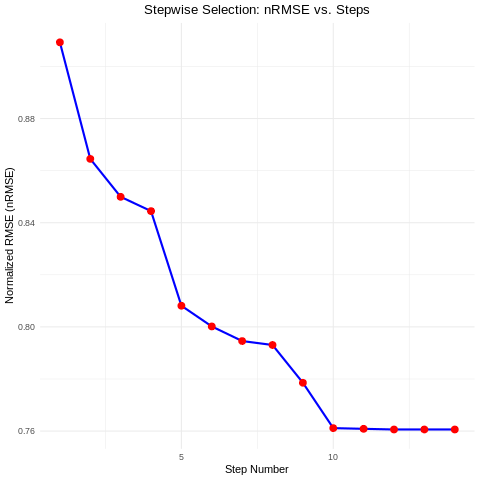

In [ ]:
%%R

# Load ggplot2
library(ggplot2)

# Assume 'result' is the output from stepwise_multivariate
result <- stepwise_multivariate(data, method = "forward", k_folds = 5)

# Extract stepwise history
stepwise_history <- result$stepwise_history

# Plot nRMSE over steps
ggplot(stepwise_history, aes(x = Step, y = nRMSE)) +
  geom_line(color = "blue", size = 1) +  # Line showing progression
  geom_point(color = "red", size = 3) +  # Highlighting each step
  theme_minimal() +
  labs(title = "Stepwise Selection: nRMSE vs. Steps",
       x = "Step Number",
       y = "Normalized RMSE (nRMSE)") +
  theme(plot.title = element_text(hjust = 0.5))

`geom_smooth()` using formula = 'y ~ x'


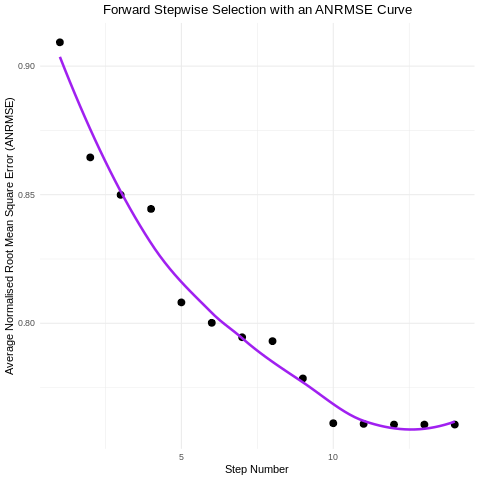

In [ ]:
%%R

ggplot(stepwise_history, aes(x = Step, y = nRMSE)) +
  geom_point(color = "black", size = 3) +  # Highlighting each step
  geom_smooth(method = "loess", color = "purple", size = 1.2, se = FALSE) +  # Smooth curve
  theme_minimal() +
  labs(title = "Forward Stepwise Selection with an ANRMSE Curve",
       x = "Step Number",
       y = "Average Normalised Root Mean Square Error (ANRMSE)") +
  theme(plot.title = element_text(hjust = 0.5))


In [ ]:
%%R

print(forward_result$stepwise_history)

   Step NumPredictors   WilksLambda     nRMSE
1     1             1  9.488794e-86 0.9092509
2     2             2 3.253668e-100 0.8644977
3     3             3 9.104184e-105 0.8499316
4     4             4 3.151409e-106 0.8444510
5     5             5 8.056533e-108 0.8081174
6     6             6 4.618381e-109 0.8001746
7     7             7 9.342444e-110 0.7945685
8     8             8 2.875871e-110 0.7930538
9     9             9 1.174305e-110 0.7785466
10   10            10 8.675821e-111 0.7611361
11   11            11 8.303051e-111 0.7608693
12   12            12 9.225964e-111 0.7606132
13   13            12            NA 0.7606132
14   14            12            NA 0.7606132


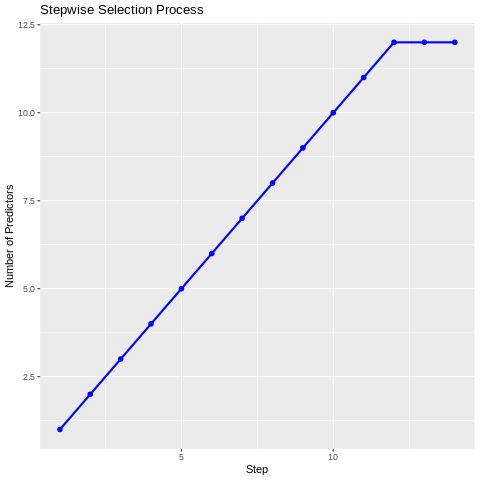

In [ ]:
%%R

library(ggplot2)

# Stepwise Selection Process Plot
ggplot(forward_result$stepwise_history, aes(x = Step, y = NumPredictors)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "blue", size = 2) +
  labs(title = "Stepwise Selection Process", x = "Step", y = "Number of Predictors")



(`geom_line()`). 

(`geom_point()`). 



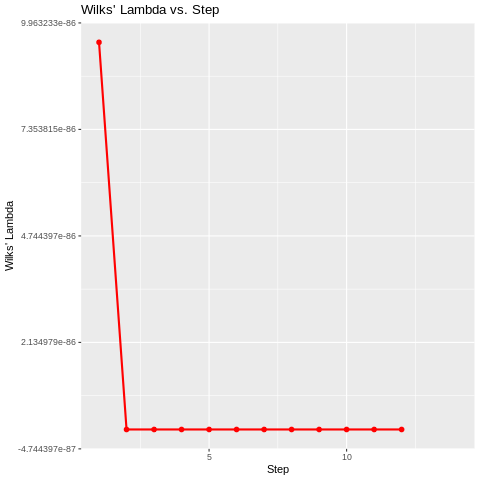

In [ ]:
%%R

# Wilks' Lambda vs. Step Plot
ggplot(forward_result$stepwise_history, aes(x = Step, y = WilksLambda)) +
  geom_line(color = "red", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "Wilks' Lambda vs. Step", x = "Step", y = "Wilks' Lambda")


(`geom_line()`). 

(`geom_point()`). 



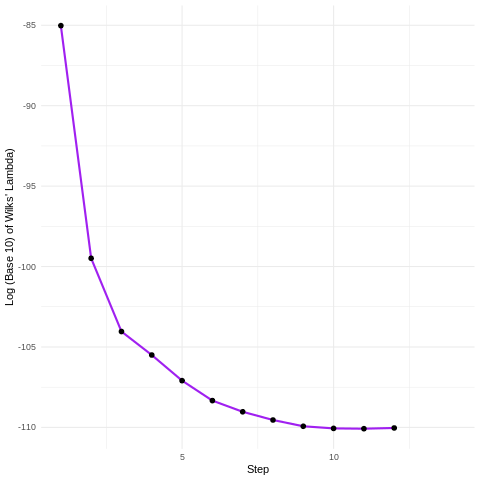

In [ ]:
%%R
library(ggplot2)

# Convert Wilks' Lambda to log scale
forward_result$stepwise_history$LogWilksLambda <- log10(forward_result$stepwise_history$WilksLambda)

# Plot with log-transformed Wilks' Lambda
ggplot(forward_result$stepwise_history, aes(x = Step, y = LogWilksLambda)) +
  geom_line(color = "purple", size = 1) +
  geom_point(color = "black", size = 2) +
  labs(x = "Step", y = "Log (Base 10) of Wilks' Lambda)") +
  theme_minimal()


In [ ]:
%%R

bidirectional_result <- stepwise_multivariate(data, method = "bidirectional")
nrmse_values <- calculate_nrmse(forward_result$model, data)

Removed Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded
Current nRMSE: 0.77610466431023
Added Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score
Current nRMSE: 0.760613207981728
No significant changes in step 1
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score
Current nRMSE: 0.760613207981728
No significant changes in step 2
Stopping selection after two consecutive failed mod

## Extra Results

Including Interaction Terms

In [ ]:
%%R

generate_interaction_terms <- function(data, predictors) {
  for (i in 1:(length(predictors) - 1)) {
    for (j in (i + 1):length(predictors)) {
      interaction_name <- paste0(predictors[i], "_x_", predictors[j])
      data[[interaction_name]] <- data[[predictors[i]]] * data[[predictors[j]]]
    }
  }
  return(data)
}

# Add interaction terms to the dataset
predictors <- setdiff(names(data), c("roe", "sustainability_score"))
data_interaction <- generate_interaction_terms(data, predictors)

bidirectional_result <- stepwise_multivariate(data_interaction, method = "bidirectional")
nrmse_values <- calculate_nrmse(bidirectional_result$model, data_interaction)

print(nrmse_values)

[1] 0.5620216


Removed Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score_x_price_cash_flow_ratio, equity_size_score_x_dividend_yield_factor, equity_size_score_x_historical_earnings_growth, equity_size_score_x_sales_growth, equity_size_score_x_asset_cash, equity_size_score_x_holdings_n_stock, equity_size_score_x_ongoing_cost, equity_size_score_x_fund_size, equity_size_score_x_rating_encoded, equity_size_score_x_risk_rating_encoded, equity_size_score_x_equity_category_encoded, price_cash_flow_ratio_x_dividend_yield_factor, price_cash_flow_ratio_x_historical_earnings_growth, price_cash_flow_ratio_x_sales_growth, price_cash_flow_ratio_x_asset_cash, price_cash_flow_ratio_x_holdings_n_stock, price_cash_flow_ratio_x_ongoing_cost, price_cash_flow_ratio_x_fund_size, price_cash_flow_ratio_x_

Including Non-Linear Terms

In [ ]:
%%R

generate_polynomial_terms <- function(data, predictors, degree = 2) {
  for (predictor in predictors) {
    for (d in 2:degree) {
      term_name <- paste0(predictor, "_degree_", d)
      data[[term_name]] <- data[[predictor]]^d
    }
  }
  return(data)
}

# Add the Polynomial Terms to the dataset
predictors <- setdiff(names(data), c("roe", "sustainability_score"))
data_nonlinear <- generate_polynomial_terms(data, predictors, degree = 2)

# Perform Stepwise Selection
result <- stepwise_multivariate(data_nonlinear, method = "bidirectional")
nrmse_values <- calculate_nrmse(result$model, data_nonlinear)
print(nrmse_values)

[1] 0.6893188


Removed Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score_degree_2, price_cash_flow_ratio_degree_2, dividend_yield_factor_degree_2, historical_earnings_growth_degree_2, sales_growth_degree_2, asset_cash_degree_2, holdings_n_stock_degree_2, ongoing_cost_degree_2, fund_size_degree_2, rating_encoded_degree_2, risk_rating_encoded_degree_2, equity_category_encoded_degree_2
Current nRMSE: 0.692207060350216
Added Predictor: equity_size_score
Selected Predictors: price_cash_flow_ratio, dividend_yield_factor, historical_earnings_growth, sales_growth, asset_cash, holdings_n_stock, ongoing_cost, fund_size, rating_encoded, risk_rating_encoded, equity_category_encoded, equity_size_score_degree_2, price_cash_flow_ratio_degree_2, dividend_yield_factor_degree_2, historical_earnings_

Extra Plots
